In [1]:
from functools import lru_cache

import cv2 as cv
import json
from matplotlib import pyplot as plt
import os
from pyrate_limiter import Duration, Rate, Limiter 
import requests
import tqdm

from pc_training.predict_brick import predict

Matplotlib created a temporary cache directory at /tmp/matplotlib-gh3_dyxb because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [27]:
data_dir_labeled = '/data/labeled'
data_dir_brickognize = '/data/brickognize'
labels = os.listdir(data_dir_labeled)
labels.sort()
labels

['15712tile1x1withopenoclip', '3023plate1x2', '43857liftarmthick1x2']

In [3]:
def store_json(json_dict, label, file_name):
    # create directory if it does not exist
    if not os.path.exists(f'{data_dir_brickognize}/{label}'):
        os.makedirs(f'{data_dir_brickognize}/{label}')
    # remove jpg extension from file_name and replace with json
    file_name = file_name.split('.')[0] + '.json'
    with open(f'{data_dir_brickognize}/{label}/{file_name}', 'w') as f:
        json.dump(json_dict, f, indent=2)

In [4]:
rate = Rate(1, Duration.SECOND)
limiter = Limiter(rate, max_delay=1000)

def brickognize_image(label, file_name):
    limiter.try_acquire('brickognize_image')
    
    url = 'https://api.brickognize.com/predict/'
    files = {
        'query_image': (file_name, open(f'{data_dir_labeled}/{label}/{file_name}', 'rb'), 'image/jpeg')
    }
    response = requests.post(url, files=files)
    store_json(response.json(), label, file_name)

In [13]:
# iterate over all labels
for label in labels:
    print(label)
    # iterate over all jpg files in the folder
    files = os.listdir(f'{data_dir_labeled}/{label}')
    files = [f for f in files if f.endswith('.jpg')]
    for file_name in tqdm.tqdm(files):
        brickognize_image(label, file_name)

15712tile1x1withopenoclip


100%|██████████| 197/197 [03:26<00:00,  1.05s/it]


3023plate1x2


100%|██████████| 190/190 [03:19<00:00,  1.05s/it]


43857liftarmthick1x2


100%|██████████| 194/194 [03:23<00:00,  1.05s/it]


In [21]:
def get_brickognize_prediction(label, jpg_file_name):
    brickognize_prediction_file = f'{data_dir_brickognize}/{label}/{jpg_file_name.split(".")[0]}.json'
    with open(brickognize_prediction_file, 'r') as f:
        brickognize_prediction = json.load(f)
    if not brickognize_prediction['items']:
        return {}
    return max(brickognize_prediction['items'], key=lambda x: x['score'])

get_brickognize_prediction("15712tile1x1withopenoclip", "20210516161839.jpg")

{'id': '15712',
 'name': 'Tile, Modified 1 x 1 with Open O Clip',
 'img_url': 'https://storage.googleapis.com/brickognize-static/thumbnails-v2.6/part/15712/0.webp',
 'external_sites': [{'name': 'bricklink',
   'url': 'https://www.bricklink.com/v2/catalog/catalogitem.page?P=15712'}],
 'category': 'Tile, Modified',
 'type': 'part',
 'score': 0.9756143093109131}

In [74]:
import pandas as pd

brickognize_predictions = pd.DataFrame()

for label in labels:
    print(label)
    # iterate over all jpg files in the folder
    files = os.listdir(f'{data_dir_labeled}/{label}')
    files = [f for f in files if f.endswith('.jpg')]
    for file_name in tqdm.tqdm(files):
        prediction = get_brickognize_prediction(label, file_name)
        prediction['label'] = label
        prediction['file_name'] = file_name
        brickognize_predictions = pd.concat([brickognize_predictions, pd.DataFrame([prediction])])
brickognize_predictions = brickognize_predictions.reset_index(drop=True)

15712tile1x1withopenoclip


100%|██████████| 197/197 [00:00<00:00, 414.87it/s]


3023plate1x2


100%|██████████| 191/191 [00:00<00:00, 420.94it/s]


43857liftarmthick1x2


100%|██████████| 193/193 [00:00<00:00, 418.78it/s]


In [75]:
brickognize_predictions.sample(20)

,id,name,img_url,external_sites,category,type,score,label,file_name
27,2555,"Tile, Modified 1 x 1 with Clip",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Tile, Modified",part,0.916664,15712tile1x1withopenoclip,20210516164055.jpg
271,3023,Plate 1 x 2,https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...",Plate,part,0.966514,3023plate1x2,20210606174146.jpg
533,43857,"Technic, Liftarm Thick 1 x 2",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.913351,43857liftarmthick1x2,20210704142842.jpg
344,3023,Plate 1 x 2,https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...",Plate,part,0.884193,3023plate1x2,20210704143932.jpg
59,2555,"Tile, Modified 1 x 1 with Clip",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Tile, Modified",part,0.957406,15712tile1x1withopenoclip,20210522092414.jpg
379,3023,Plate 1 x 2,https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...",Plate,part,0.968362,3023plate1x2,20240515115814.jpg
291,3023,Plate 1 x 2,https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...",Plate,part,0.961708,3023plate1x2,20210608143831.jpg
131,15712,"Tile, Modified 1 x 1 with Open O Clip",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Tile, Modified",part,0.965189,15712tile1x1withopenoclip,20210704143211.jpg
300,3023,Plate 1 x 2,https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...",Plate,part,0.970152,3023plate1x2,20210608145746.jpg
421,43857,"Technic, Liftarm Thick 1 x 2",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.895414,43857liftarmthick1x2,20210516164943.jpg


In [76]:
label_id_mapping = {
    '15712tile1x1withopenoclip': [2555, 15712], 
    '3023plate1x2': [3023], 
    '43857liftarmthick1x2': [43857],
}
def is_correct_prediction(row):
    try:
        label = row['label']
        prediction = int(row['id'])
        return prediction in label_id_mapping[label]
    except ValueError:
        return False

print(is_correct_prediction(brickognize_predictions.iloc[0]))
brickognize_predictions.iloc[0]

True


id                                                            15712
name                          Tile, Modified 1 x 1 with Open O Clip
img_url           https://storage.googleapis.com/brickognize-sta...
external_sites    [{'name': 'bricklink', 'url': 'https://www.bri...
category                                             Tile, Modified
type                                                           part
score                                                      0.960547
label                                     15712tile1x1withopenoclip
file_name                                        20210501123737.jpg
Name: 0, dtype: object

In [77]:
# Add column to indicate if the prediction is correct
brickognize_predictions['correct'] = brickognize_predictions.apply(is_correct_prediction, axis=1)
brickognize_predictions.sample(20)

,id,name,img_url,external_sites,category,type,score,label,file_name,correct
500,43857,"Technic, Liftarm Thick 1 x 2",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.975333,43857liftarmthick1x2,20210626152126.jpg,True
454,43857,"Technic, Liftarm Thick 1 x 2",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.958832,43857liftarmthick1x2,20210605093414.jpg,True
303,3023,Plate 1 x 2,https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...",Plate,part,0.927768,3023plate1x2,20210608150037.jpg,True
369,3023,Plate 1 x 2,https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...",Plate,part,0.917084,3023plate1x2,20210724115723.jpg,True
557,60483,"Technic, Liftarm Thick 1 x 2 - Axle Hole",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.714654,43857liftarmthick1x2,20210724115458.jpg,False
308,3023,Plate 1 x 2,https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...",Plate,part,0.931160,3023plate1x2,20210626151758.jpg,True
225,3023,Plate 1 x 2,https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...",Plate,part,0.970597,3023plate1x2,20210516164021.jpg,True
223,3023,Plate 1 x 2,https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...",Plate,part,0.983719,3023plate1x2,20210516163956.jpg,True
575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43857liftarmthick1x2,20240515120203.jpg,False
457,43857,"Technic, Liftarm Thick 1 x 2",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.859546,43857liftarmthick1x2,20210605093614.jpg,True


In [78]:
# Sample some rows where a prediction was made (id is not NaN) but it is incorrect
actual_predictions = brickognize_predictions.dropna(subset=['id'])
incorrect_predictions = actual_predictions[~actual_predictions['correct']]
incorrect_predictions.sample(20)

,id,name,img_url,external_sites,category,type,score,label,file_name,correct
561,60483,"Technic, Liftarm Thick 1 x 2 - Axle Hole",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.892193,43857liftarmthick1x2,20210724115958.jpg,False
555,60483,"Technic, Liftarm Thick 1 x 2 - Axle Hole",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.824204,43857liftarmthick1x2,20210724115316.jpg,False
522,60483,"Technic, Liftarm Thick 1 x 2 - Axle Hole",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.811138,43857liftarmthick1x2,20210626161050.jpg,False
535,60483,"Technic, Liftarm Thick 1 x 2 - Axle Hole",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.701838,43857liftarmthick1x2,20210704143056.jpg,False
388,32523,"Technic, Liftarm Thick 1 x 3",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.768359,43857liftarmthick1x2,20210501123640.jpg,False
556,60483,"Technic, Liftarm Thick 1 x 2 - Axle Hole",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.724195,43857liftarmthick1x2,20210724115428.jpg,False
548,60483,"Technic, Liftarm Thick 1 x 2 - Axle Hole",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.799958,43857liftarmthick1x2,20210704150104.jpg,False
112,6231,Panel 1 x 1 x 1 Corner,https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...",Panel,part,0.849423,15712tile1x1withopenoclip,20210626152645.jpg,False
428,60483,"Technic, Liftarm Thick 1 x 2 - Axle Hole",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.679021,43857liftarmthick1x2,20210516165912.jpg,False
463,32523,"Technic, Liftarm Thick 1 x 3",https://storage.googleapis.com/brickognize-sta...,"[{'name': 'bricklink', 'url': 'https://www.bri...","Technic, Liftarm",part,0.766364,43857liftarmthick1x2,20210606174411.jpg,False


In [79]:
import numpy as np
from functools import lru_cache

@lru_cache(maxsize=None)
def load_image(url):
    req = requests.get(url)
    return cv.imdecode(np.frombuffer(req.content, np.uint8), cv.IMREAD_COLOR)

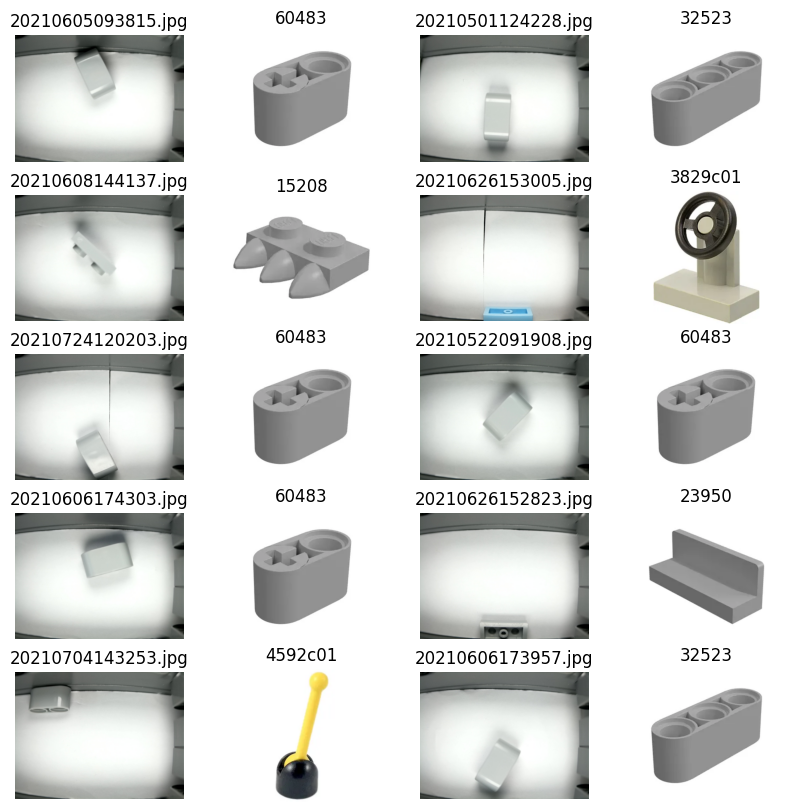

In [80]:

# Sample 10 incorrect predictions and create a plot showing the image from disk and the img_url
plt.figure(figsize=(10, 10))
i = 0
for idx, row in incorrect_predictions.sample(10).iterrows():
    ax = plt.subplot(5, 4, i + 1)
    label = row['label']
    file_name = row['file_name']
    img = cv.imread(f'{data_dir_labeled}/{label}/{file_name}')
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(file_name)
    plt.axis('off')
    ax = plt.subplot(5, 4, i + 2)
    ref = load_image(row['img_url'])
    plt.imshow(cv.cvtColor(ref, cv.COLOR_BGR2RGB))
    plt.title(row['id'])
    plt.axis('off')
    i += 2    

In [87]:
# count the correct and incorrect predictions by label and show the median score
brickognize_predictions.groupby(['label', 'correct']).agg({'score': 'median', 'id': 'count'})

score   id
label                     correct               
15712tile1x1withopenoclip False    0.729236    4
                          True     0.966052  176
3023plate1x2              False    0.733450    8
                          True     0.954485  176
43857liftarmthick1x2      False    0.766364   63
                          True     0.954030  117

In [83]:
# count number of nan values in the id column
brickognize_predictions['id'].isna().sum()

np.int64(37)